# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №4: Линейные модели


###### <hr\>
**Общая информация**

**Срок сдачи:** 6 декабря 2017, 06:00 <br\>
**Штраф за опоздание:** -2 балла после 06:00 6 декабря, -4 балла после 06:00 13 декабря, -6 баллов после 06:00 20 декабря

При отправлении ДЗ указывайте фамилию в названии файла<br\>

Используйте данный Ipython Notebook при оформлении домашнего задания.
<hr\>

In [41]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, roc_auc_score, auc, accuracy_score
from collections import Counter
%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

Укажите свою фамилию на русском языке в поле ниже.

In [4]:
USER_NAME = u"Фельдман".lower()
REGULARIZATIONS = ["L1", "L2"]
ALGORITHM = ["", "Mini Batch"]

print "Имплементируйте обучение логистической регрессии с %s регуляризацией с помощью метода %s Stochastic Gradient Descent (SGD)"\
% (
    REGULARIZATIONS[hash(USER_NAME) % 2],
    ALGORITHM[hash(USER_NAME[::-1]) % 2]
)

Имплементируйте обучение логистической регрессии с L2 регуляризацией с помощью метода Mini Batch Stochastic Gradient Descent (SGD)


#### Замечания
* В SGD градиент расчитывается по одному случайному объекту, т.е. в алгоритме надо
    * Перемешать выборку
    * Посчтитать градиент на одном объекте
    * Сделать шаг спуска
* В Mini Batch SGD - по подвыборке объектов т.е в алгоритме надо
    * Перемешать выборку
    * Разбить на части (примерно) одинакового размера - мини батчи
    * Почитать градиент по мини батчам
    * Сделать шаг спуска
* Сделайте убывающую скорость спуска, например `alpha/n_epoch` или `alpha/n_iter` или `alpha/n_batch` или ...
* Для отладки работы алгоритма, реализуйте возможность сохранения или вывода ошибки модели после очередной итерации/батча/эпохи.
* Правило останова - максимальное количество эпох
    
Эпохой в SGD и MB-SGD называется один проход по **всем** объектам в обучающей выборке (тем или иным способом)

### Примечание для случая L1-регуляризации:

При расчете производной по функции потерь
$$ L(w_0,w_1,\dots) = - \frac{1}{N}\left[\sum_i \log(\sigma(y^{(i)} g(x^{(i)}))\right] + \frac{1}{C}\sum_{j=1}^{m}|w_j| $$
могут возникнуть сомнения по поводу производной части с модулями. 

Вам на выбор предлагаются следующией варианты:
* Считать субградиент $\partial|w_j| = sign(w_j)$ (проще, но с большой вероятностью не приведет к занулению коэффициентов)
* Метод SGD-Clipping из [статьи](https://www.aclweb.org/anthology/P/P09/P09-1054.pdf) - раздел 3.1, страница 479, правая колонка снизу (чуть сложнее, но зато должно занулять)
* Cumulative Penalty из той же [статьи](https://www.aclweb.org/anthology/P/P09/P09-1054.pdf) - раздел 3.2

# Реализация модели

## Вывод правила обновления весов (1 балл)

Выведите правило обновления весов на каждом шаге алгоритма. Иными словами, посчитайте производную (градиент) функции потерь с регуляризацией. Формулы надо оформлять в формате LaTeX.



$$
 \frac{\partial L}{\partial w}=(y - \sigma(X \cdot w))X+2C \cdot w
$$



## Имплементация (5 баллов)

In [60]:
from sklearn.base import BaseEstimator, ClassifierMixin

class MySGDClassifier(BaseEstimator, ClassifierMixin):
    
    def __init__(self, C=1, alpha=0.01, max_epoch=10, verb=True, batches=100):     
        self.C = C
        self.alpha = alpha
        self.max_epoch = max_epoch
        self.verb = verb
        self.batches = batches
    
    def sigmoid(self, scores):
        return 1 / (1 + np.exp(-scores))

    def log_likelihood(self, X, y, weights, C):
        scores = np.dot(X, weights)
        ll = np.mean( -y*np.log(self.sigmoid(scores)) - (1-y) * np.log(1 - self.sigmoid(scores)))
        return ll + C * np.sum(weights ** 2)
    
    def logistic_regression(self, X, y, max_epoch, learning_rate, C, batch_size):        
        intercept = np.ones((X.shape[0], 1))
        X = np.hstack((intercept, X))
        weights = np.zeros(X.shape[1])
        batch_num = 0
        mini_batch = X[:batch_size]
        loss = []
        for step in xrange(max_epoch):
            
            for i in range(X.shape[0] / batch_size):
                gradient = np.dot((self.sigmoid(np.dot(mini_batch, weights)) - y[batch_num * batch_size:(batch_num + 1) * batch_size]), mini_batch) + C * 2 * weights 
                weights -= (learning_rate / (step + 1)) * gradient
                
                batch_num += 1
                mini_batch = X[batch_num * batch_size:(batch_num + 1) * batch_size]
            if step % 1 == 0 and self.verb:
                print self.log_likelihood(X, y, weights, C)
            batch_num = 0
            mini_batch = X[:batch_size]

            loss.insert(len(loss), self.log_likelihood(X, y, weights, C))
        return weights, loss
    
    def fit(self, X, y=None):
        ind = np.random.permutation(X.shape[0])
        batch_size = X.shape[0] / self.batches
        self.weights, self.loss = self.logistic_regression(X[ind], y[ind], self.max_epoch, self.alpha, self.C, batch_size)       
        return self
    
        
    def predict(self, X):
        intercept = np.ones((X.shape[0], 1))
        X = np.hstack((intercept, X))
        final_scores = np.dot(X, self.weights)
        return np.round(self.sigmoid(final_scores))
            
    def predict_proba(self, X):
        intercept = np.ones((X.shape[0], 1))
        X = np.hstack((intercept, X))
        final_scores = np.dot(X, self.weights)
        return self.sigmoid(final_scores)

## Проверка на синтетических данных (1 балл)

Запустите ваш алгоритм на синтетических данных. 
Выведите полученные веса и нарисуйте разделяющую границу между классами.

0.359984403923
0.337782210673
0.330401145067
0.326564432703
0.324326758648
0.322896308176
0.321899474744
0.321151726185
0.320558343061
0.320068763617


MySGDClassifier(C=0.001, alpha=0.1, batches=100, max_epoch=10, verb=True)

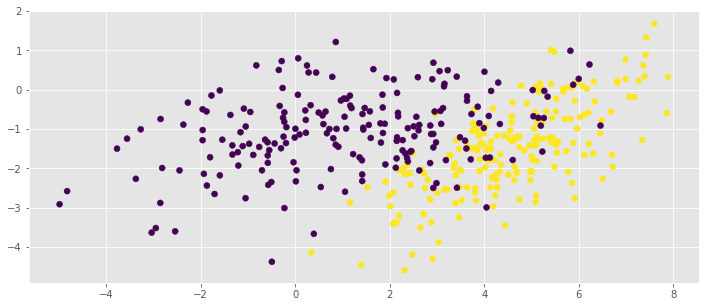

In [61]:
np.random.seed(0)
N_samples = 200
C1 = np.array([[0., -0.8], [1.5, 0.8]])
C2 = np.array([[1., -0.7], [2., 0.7]])
gauss1 = np.dot(np.random.randn(N_samples, 2) + np.array([5, 3]), C1)
gauss2 = np.dot(np.random.randn(N_samples, 2) + np.array([1.5, 0]), C2)

X = np.vstack([gauss1, gauss2])
y = np.r_[np.ones(N_samples), np.zeros(N_samples)]


plt.scatter(X[:,0], X[:,1], c=y)

model = MySGDClassifier(alpha=0.1, C = 0.001, max_epoch=10)
model.fit(X, y)

# Точность разделения

In [62]:
pred = model.predict(X)
print 'Accuracy score:', accuracy_score(y_pred=pred, y_true=y)

Accuracy score: 0.9


# ROC AUC

In [63]:
proba = model.predict_proba(X)
print 'ROC AUC: ', roc_auc_score(y, proba)

ROC AUC:  0.947225


# Разделяющая граница между классами

In [64]:
model.weights

array([-4.6203336 ,  1.06244876, -1.14330357])

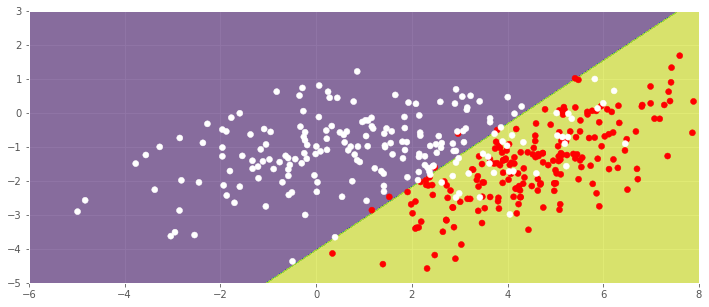

In [65]:

h = 0.01
x_min, x_max = -6, 8
y_min, y_max = -5, 3
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
xr = xx.ravel()
yr = yy.ravel()
xy = np.vstack((xr, yr)).T
y_ = model.predict(xy)
y_ = y_.reshape(xx.shape)
plt.contourf(xx, yy, y_, alpha=0.6)
colors = []
for i in xrange (y.shape[0]):
    if y[i] == 1:
        colors.insert(len(colors), 'r')
    else:
        colors.insert(len(colors), 'w')
plt.scatter(X[:, 0], X[:, 1],c=colors)

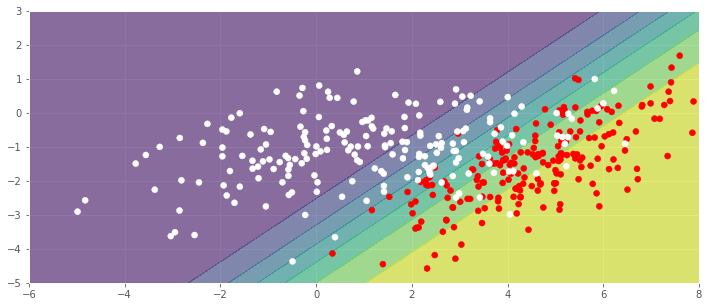

In [66]:
y_ = model.predict_proba(xy)
y_ = y_.reshape(xx.shape)
plt.contourf(xx, yy, y_, alpha=0.6)
plt.scatter(X[:, 0], X[:, 1],c=colors)

## Анализ сходимости (2 балла)

Для следующих заданий используйте датасет ниже

In [67]:
from sklearn.datasets import make_classification

In [68]:
X, y = make_classification(n_samples=100000, n_features=10, 
                           n_informative=4, n_redundant=0, 
                           random_state=123, class_sep=1.0,
                           n_clusters_per_class=1)

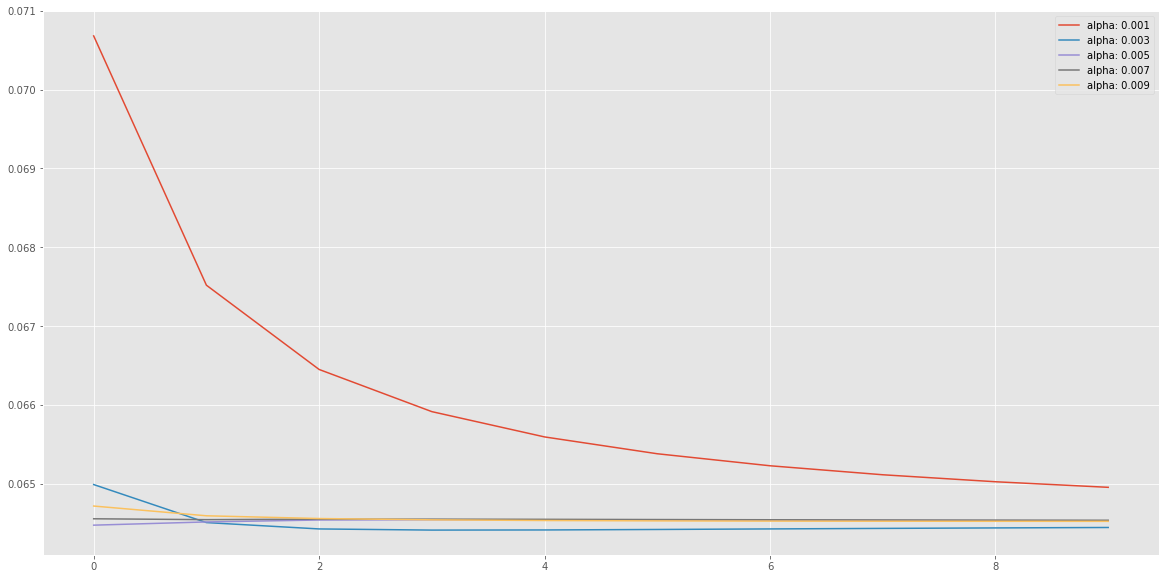

In [69]:
plt.figure(figsize=(20,10))

loss = []
i = 0
for alpha in np.arange(0.001,0.01,0.002):
    model = MySGDClassifier(C=0.0001, alpha=alpha,max_epoch=10,verb=False)
    model.fit(X,y)
    loss.insert(len(loss), model.loss)
    plt.plot(range(10),loss[i],label='alpha: {}'.format(alpha))
    i += 1
plt.legend()

Покажите сходимость вашего метода: изобразите графики зависимости значения функции потерь (по всей выборке) после очередной итерации/батча/эпохи (выбрать одно) для разных `alpha`.

## Эффект регуляризации (2 балла)

Изобразите значения коэффициентов модели для каждого С из `np.logspace(3, -3, 10)` (желательно на одном и том же графике)

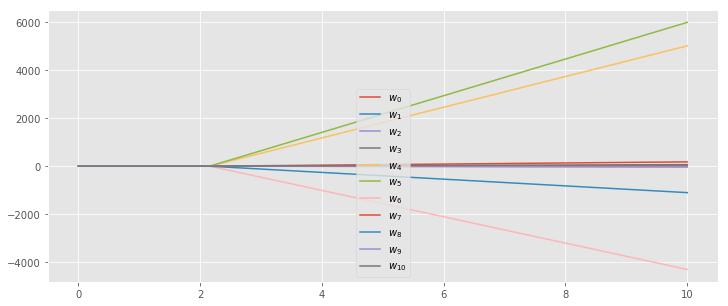

In [72]:
## Your Code Here
weights = np.zeros((10, X.shape[1] + 1))
i = 0
for C in np.logspace(3, -3, 10):
    model = MySGDClassifier(C, alpha=0.1, max_epoch=1,verb=False,batches=1000)
    model.fit(X, y)
    weights[i] = model.weights
    i += 1

for i in xrange(len(weights[0])):
    lbl = r'w_{}'.format(i)
    plt.plot(np.logspace(3,-3,10),weights[:,i], label=r'$w_{%d}$' %i)
    
plt.legend()    

# Боевое применение

## О hearthstone

[Hearthstone](http://eu.battle.net/hearthstone/ru/) - карточная он-лайн игра по мотивам вселенной Warcraft.

Каждый игрок играет за персонажа определенного класса и собирает колоду карт которую может разыгрывать во время игры. Для дальнейших деталей обратитесь к [wiki](https://ru.wikipedia.org/wiki/Hearthstone), посмотрите youtube или поиграйте сами (но не долго =) ).

Теми или иными способами игрок может отнимать жизни у своего оппонента, таким образом цель раунда - побить другого игрока.

<center><img src='http://ps3hits.ru/wp-content/uploads/2015/08/hearthstone-game-sshot-1.jpg'></center>

## Постановка задачи

В рамках конференции [AAIA 17](https://fedcsis.org/2017/aaia) было запущено [соревнование](https://knowledgepit.fedcsis.org/contest/view.php?id=120) по предсказанию исхода раунда в heartstone. 

Используя признаки, которые описывают текущее состояние раунда необходимо предсказать **вероятность** победы игрока в этом раунде.

Качество модели измеряется с помощью **ROC-AUC**

## Данные

Обучающую выборку и тестовую выборку с ответами можно скачать [отсюда](https://cloud.mail.ru/public/BEon/4Rrdqqvng)

Данные содержат набор информации о раунде в некоторый момент времени: жизни игрока и оппонента, номер хода, карты на столе, карты в руке игрока, количество карт в руке оппонента и тп.<br/>
По игроку №1 (далее просто **игрок**) помимо всего прочего известен набор карт "в руке".</br>
По игроку №2 (далее просто **оппонент**) эта информация отсутствует.</br>


В данных для обучению содержится 2 млн. игр, разбитых на 4 файла. Названия признаков говорят сами за себя.
Целевой признак - `decision` (1 - победил игрок, 0 - победил оппонент).

## Работа с простыми табличными данными (1 балл)

По соображениям сокращения времени вычислений, проделаем основные шаги по одной части данных.

Если все данные не будут помещаться вам с оперативную память, то можете использовать один из 4х файлов для обучения

In [80]:
# Загрузка данных целиком
# df_list = []
# for chunk in range(1,5):
#     filepath = './trainingData_tabular_chunk%d.csv' % chunk
#     df_list.append(pd.read_csv(filepath, sep=','))
# df_data = pd.concat(df_list)

# Загрузка одной части данных
filepath = './trainingData_tabular_chunk1.csv'
df_data = pd.read_csv(filepath, sep=',')

In [81]:
df_data.shape

(500000, 45)

In [82]:
# для удобства
df_data.columns = df_data.columns.str.replace('.', '_')
df_data = df_data.set_index('gamestate_id')

In [83]:
df_data.head().T

gamestate_id,4687346,3270826,3189487,4098946,2661127
decision,1,1,1,1,0
turn,14,7,5,8,13
opponent_armor,0,0,3,0,0
opponent_attack,0,0,0,0,0
opponent_hero_card_id,798,754,612,390,25
opponent_hp,5,22,29,26,30
opponent_special_skill_used,0,0,0,0,0
opponent_weapon_durability,0,0,0,0,0
opponent_crystals_all,10,6,4,7,10
opponent_crystals_current,10,6,1,7,1


In [84]:
# Распределение классов
df_data.decision.mean()

# Примерно поровну

0.504702

#### Задание

* Определите количество уникальных карт героя у игрока и оппонента.
* Преобразуйте категориальные переменные с помощью one-hot кодирования, добавьте к датасету и удалите прежние столбцы


In [85]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

unique_cards = np.array([df_data['player_hero_card_id'].unique(), df_data['opponent_hero_card_id'].unique()])
unique_cards.resize(unique_cards.shape[1] * 2)

label_encode = LabelEncoder()
label_encode.fit(unique_cards)

ohe = OneHotEncoder()
ohe.fit(np.arange(label_encode.classes_.shape[0]).reshape(-1,1))
print 'Total unique cards: ', label_encode.classes_.shape[0]

player_onehot = np.asarray(ohe.transform(label_encode.transform(df_data['player_hero_card_id']).reshape(-1,1)).todense())
opponent_onehot = np.asarray(ohe.transform(label_encode.transform(df_data['opponent_hero_card_id']).reshape(-1,1)).todense())

for i in range(player_onehot.shape[1]):
    df_data['player_hcid_onehot_%d' % i] = player_onehot[:, i]
    df_data['opponent_hcid_onehot_%d' % i] = opponent_onehot[:, i]
df_data = df_data.drop(['player_hero_card_id', 'opponent_hero_card_id'], axis=1)


Total unique cards:  9


## Обучение модели (1 балл)

#### Задание

* Получите матрицу объект признак `X` и вектор целевого признака `y`
* Создайте Pipeline из `StandartScaller` и вашей модели
* Обучите модель (подбирать гиперпараметры можно без фанатизма)

In [86]:
## Youd Code Here
y = df_data.iloc[:,0].values
X = df_data.iloc[:,1:].values

ss = StandardScaler()
model = MySGDClassifier(C=0.001, alpha=0.1,max_epoch=1,verb=False)

s_model = Pipeline([('scaler', ss), ('model', model)])
s_model.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('model', MySGDClassifier(C=0.001, alpha=0.1, batches=100, max_epoch=1, verb=False))])

## Применение модели (2 балла)
#### Задание
* Загрузите тестовые данные
* Подготовте их к подаче на вход в алгоритм
* Примените модель оцените качество с помощью меры ROC-AUC


In [94]:
## Youd Code Here
df_list = []
for i in xrange(5,8):
    df_list.append(pd.read_csv('testData_tabular_chunk' + str(i) + '.csv'))
df_data_test = pd.concat(df_list)

df_data_test.columns = df_data_test.columns.str.replace('.', '_')
df_data_test = df_data_test.set_index('gamestate_id')

In [95]:
player_onehot = np.asarray(ohe.transform(le.transform(df_data_test['player_hero_card_id']).reshape(-1,1)).todense())
opponent_onehot = np.asarray(ohe.transform(le.transform(df_data_test['opponent_hero_card_id']).reshape(-1,1)).todense())

for i in range(player_onehot.shape[1]):
    df_data_test['player_hcid_onehot_%d' % i] = player_onehot[:, i]
    df_data_test['opponent_hcid_onehot_%d' % i] = opponent_onehot[:, i]
df_data_test = df_data_test.drop(['player_hero_card_id', 'opponent_hero_card_id'], axis=1)



In [96]:
y_test = np.loadtxt('deprecated_testLabels.txt')
X_test = df_data_test.iloc[:,1:].values
y_ = s_model.predict_proba(X_test)

print 'ROC AUC:', roc_auc_score(y_test, y_)

ROC AUC: 0.662627406994
